# To-Do next:
1. ~~Make `scene_path` update using `get_scene_path`~~
2. ~~Update `scene` in `sim_settings` to use the new `scene_path`~~
3. ~~Fix the positioning of agent on the map (done?)~~
4. ~~Create a video showing the agent spinning around to demonstrate environment~~
5. Check to see if there is a better way to account for agent height (?)
6. ~~Work out 360 view~~ _(Assuming that this is not required for now)_
7. Function-ise everything
8. Hook up a ViT

# Major milestones
1. ~~Map agent in environment~~
2. Agent random-walk with position trace
3. Work out 360 view
4. Hook up vision transformer
5. Hook up LLM
6. Hook up second vision transformer
7. ??
8. Write-up

# Preamble
Setting up:
 - Required modules
 - Folder paths
 - Useful functions
 - Creating simulator instance and reading in the data

In [1]:
# Required imports
import os
import json
import numpy as np
import pandas as pd
import random
import imageio
import magnum as mn
from PIL import Image
from matplotlib import pyplot as plt
import math
import cv2

import habitat_sim
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut
import magnum as mn

In [2]:
# setting up folder paths
habitat_dir_path = "/home/wes/habitat/data/"
rxr_data_path = "/media/wes/Lexar/rxr_data/rxr-data/"
output_dir_path = "/home/wes/Documents/git_ws/OCOM5300M_ResearchProject/outputs/"

scene_dir_path = os.path.join(habitat_dir_path, f"scene_datasets/mp3d/")
pose_dir_path = os.path.join(rxr_data_path, f'pose_traces/rxr_train/')
mp3d_scene_config = os.path.join(scene_dir_path, f"mp3d.scene_dataset_config.json")

scene_path = ''

In [3]:
# checking that paths exist
print(f'scene_dir_path: {scene_dir_path}, \t exists: {os.path.exists(scene_dir_path)}')
print(f'pose_dir_path: {pose_dir_path}, \t exists: {os.path.exists(pose_dir_path)}')
print(f"mp3d_scene_config: {mp3d_scene_config}, \t exists: {os.path.exists(mp3d_scene_config)}")

scene_dir_path: /home/wes/habitat/data/scene_datasets/mp3d/, 	 exists: True
pose_dir_path: /media/wes/Lexar/rxr_data/rxr-data/pose_traces/rxr_train/, 	 exists: True
mp3d_scene_config: /home/wes/habitat/data/scene_datasets/mp3d/mp3d.scene_dataset_config.json, 	 exists: True


## Preamble: Utility Functions
### Path updates

In [4]:
def get_scene_path(scene_id):
    global scene_dir_path
    return os.path.join(scene_dir_path, f"{scene_id}/{scene_id}.glb")

In [5]:
def update_scene_path(scene_id):
    global scene_dir_path
    scene_path = get_scene_path(scene_id)

    return scene_id, scene_path

### Display Observations

In [6]:
# Change to do something like this maybe: https://stackoverflow.com/a/41432704
#    i.e. show multiple subplots on one plot
def display_sample(rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])):
    from habitat_sim.utils.common import d3_40_colors_rgb

    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")

    arr = [rgb_img]
    titles = ["rgb"]
    if semantic_obs.size != 0:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(12, 8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)


if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--no-display", dest="display", action="store_false")
    parser.add_argument("--no-make-video", dest="make_video", action="store_false")
    parser.set_defaults(show_video=True, make_video=True)
    args, _ = parser.parse_known_args()
    show_video = args.display
    display = args.display
    do_make_video = args.make_video
else:
    show_video = False
    do_make_video = False
    display = False

# import the maps module alone for topdown mapping
if display:
    from habitat.utils.visualizations import maps

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring


### Configuring Simulator Settings

In [7]:
# Default sim settings
rgb_sensor = True
depth_sensor = True
semantic_sensor = False
seed = 1
number_images_for_panorama = 4 # number of images required for a full 360 degree panorama to be created


sim_settings = {
    "width": 256,  # Spatial resolution of the observations
    "height": 256,
    "scene": scene_path,  # Scene path
    "scene_dataset": mp3d_scene_config,  # the scene dataset configuration files
    "default_agent": 0,
    "sensor_height": 1.0,  # Height of sensors in meters
    "color_sensor": rgb_sensor,  # RGB sensor
    "depth_sensor": depth_sensor,  # Depth sensor
    "semantic_sensor": semantic_sensor,  # Semantic sensor
    "seed": seed,  # used in the random navigation
    "enable_physics": False,  # kinematics only    
    "hfov" : 360 / number_images_for_panorama
}

In [8]:
# Sim config factory?
def make_cfg(settings):
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.gpu_device_id = 0
    sim_cfg.scene_id = settings["scene"]
    sim_cfg.scene_dataset_config_file = settings["scene_dataset"]
    sim_cfg.enable_physics = settings["enable_physics"]

    sensor_specs = []

    # RGB sensor specs
    color_sensor_spec = habitat_sim.CameraSensorSpec()
    color_sensor_spec.uuid = "color_sensor"
    color_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
    color_sensor_spec.resolution = [settings["height"], settings["width"]]
    color_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    color_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    color_sensor_spec.hfov = settings["hfov"]
    sensor_specs.append(color_sensor_spec)

    # Depth sensor specs
    depth_sensor_spec = habitat_sim.CameraSensorSpec()
    depth_sensor_spec.uuid = "depth_sensor"
    depth_sensor_spec.sensor_type = habitat_sim.SensorType.DEPTH
    depth_sensor_spec.resolution = [settings["height"], settings["width"]]
    depth_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    depth_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    depth_sensor_spec.hfov = settings["hfov"]
    sensor_specs.append(depth_sensor_spec)

    #agent movement
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    agent_cfg.sensor_specifications = sensor_specs
    agent_cfg.action_space = {
        "move_forward" : habitat_sim.agent.ActionSpec(
            "move_forward", habitat_sim.agent.ActuationSpec(amount=0.25)
        ),
        "turn_left":habitat_sim.agent.ActionSpec(
            "turn_left", habitat_sim.agent.ActuationSpec(amount=30.0)
        ),
        "turn_right":habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=30.0)
        )
    }
    return habitat_sim.Configuration(sim_cfg, [agent_cfg])


### Loading annotations file

In [9]:
# Utility function to read rxr data and return it as a dataframe
def json_to_df(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))

    return pd.DataFrame(data)    

### Translating `rxr` viewpoint IDs into `habitat-sim` positions

In [10]:
# TBD: turn rxr viewpoint IDs into habitat-sim positions on a map

## Reading in the `rxr` data

In [11]:
# Checking file path
annotations_fname = "rxr_train_guide.jsonl/rxr_train_guide.json"
annotations_path = os.path.join(rxr_data_path, annotations_fname)
print(f'Checking existence of {annotations_path}: \t {os.path.exists(annotations_path)}')

Checking existence of /media/wes/Lexar/rxr_data/rxr-data/rxr_train_guide.jsonl/rxr_train_guide.json: 	 True


In [12]:
df_rxr = json_to_df(annotations_path)

# only interested in the English instructions at this time
df_rxr = df_rxr[df_rxr['language']=='en-US']
df_rxr.head(5)

,path_id,split,scan,heading,path,instruction_id,annotator_id,language,instruction,timed_instruction,edit_distance
0,0,train,SN83YJsR3w2,2.631565,"[4471fcf26b3847ed88ce41eca5ecb13d, b2b0b597ef2...",0,0,en-US,You will start by standing in front of a glass...,"[{'end_time': 1.5, 'word': 'You', 'start_time'...",0.076923
21,12,train,7y3sRwLe3Va,5.875003,"[60ce99b0264148c09db7ef836ad77e3f, dd83fb40a2e...",28,44,en-US,"You're starting in a closet, facing empty shel...","[{'start_time': 3.5, 'end_time': 3.8, 'word': ...",0.061920
47,24,train,S9hNv5qa7GM,4.879265,"[65683a5cc3564769947019eb7e63ef0d, bd9faec23bb...",60,81,en-US,"You begin facing a wall, turn to your left, ta...","[{'word': 'You', 'start_time': 1.0, 'end_time'...",0.041667
54,27,train,ur6pFq6Qu1A,2.913781,"[23b6df4fc549460daab1c23d3674f845, 96b2d4806ff...",67,86,en-US,You're looking at a Japanese decorative plate ...,"[{'start_time': 2.5, 'end_time': 3.0, 'word': ...",0.137037
55,29,train,mJXqzFtmKg4,1.764716,"[b7dd551438384d4da9530d3815d3aa90, 50d87f990a7...",71,81,en-US,"You begin facing a bunch of cabinets, moving s...","[{'start_time': 1.4, 'word': 'You', 'end_time'...",0.070600


In [13]:
# choosing a scan for testing purposes
scene_id, scene_path = update_scene_path(df_rxr['scan'].iloc[1])
sim_settings['scene'] = scene_path

# finding all instructions relating to that scene
df_instruction = df_rxr[df_rxr['scan']==scene_id]
df_instruction.head()

,path_id,split,scan,heading,path,instruction_id,annotator_id,language,instruction,timed_instruction,edit_distance
21,12,train,7y3sRwLe3Va,5.875003,"[60ce99b0264148c09db7ef836ad77e3f, dd83fb40a2e...",28,44,en-US,"You're starting in a closet, facing empty shel...","[{'start_time': 3.5, 'end_time': 3.8, 'word': ...",0.061920
593,399,train,7y3sRwLe3Va,6.143116,"[0e9fdd85e24a4a35b3dc1e8cb76ebb09, f3e7de357f2...",923,160,en-US,You're currently inside a white bathroom. Turn...,"[{'start_time': 2.1, 'end_time': 2.6, 'word': ...",0.115789
656,440,train,7y3sRwLe3Va,1.265834,"[f3e7de357f254d15bb79bc62ef0c803e, 3429ecc6a32...",1008,104,en-US,Starting in a bedroom looking forward. To your...,"[{'start_time': 3.1, 'end_time': 3.5, 'word': ...",0.188679
2354,1533,train,7y3sRwLe3Va,0.824239,"[3fe5daf13a5546069766f1c4bfd50fcc, 204fc459fd2...",3704,0,en-US,You will start by standing inside a room with ...,"[{'end_time': 1.9, 'start_time': 1.4, 'word': ...",0.064846
2961,1943,train,7y3sRwLe3Va,3.188939,"[0eb1323894e041efa23d2f3e60efbe44, 1410b021e1c...",4701,133,en-US,"You're standing in a doorway, behind you see a...","[{'word': 'You're', 'start_time': 5.1, 'end_ti...",0.319920


In [14]:
# finding the pose traces relating to that particular instruction
instruction_id = df_instruction['instruction_id'].iloc[0]
instruct_id = ('000000' + str(instruction_id))[-6:]
print(f'pose_dir_path: {pose_dir_path}, \t exists: {os.path.exists(pose_dir_path)}')
print(f'instruct_id: {instruct_id}')
print(f'Instructions: {df_instruction["instruction"].iloc[0]}')

pose_dir_path: /media/wes/Lexar/rxr_data/rxr-data/pose_traces/rxr_train/, 	 exists: True
instruct_id: 000028
Instructions: You're starting in a closet, facing empty shelves and a drawer unit. To your left, is the door to exit, and just beyond that, is another door that leads into a hallway. Walk through the closet door and that second door toward the hallway. When you get in the threshold between the bedroom and the hallway with the stairs, you're finished.


In [15]:
# Retrieving the pose trace
pose_trace_path = os.path.join(pose_dir_path, f'{instruct_id}_guide_pose_trace.npz')
print(f'{pose_trace_path} exists: {os.path.exists(pose_trace_path)}')

/media/wes/Lexar/rxr_data/rxr-data/pose_traces/rxr_train/000028_guide_pose_trace.npz exists: True


In [16]:
pose_trace = np.load(pose_trace_path)
poses = pose_trace['extrinsic_matrix']
print(poses.shape)

(2014, 4, 4)


In [17]:
poses_pano = pose_trace['pano']
poses_pano[0] == df_instruction['path'].iloc[0][0]

True

In [18]:
# Getting list of unique positions and rotations

# Creating np array with proper dimensions
unique_position_list = np.zeros((1,3))
unique_rotation_list = np.zeros((1,3,3))
for pose in poses:
    if not np.all(np.isin(pose[:3,3], unique_position_list)):
        unique_position_list = np.append(unique_position_list, np.array(pose[:3,3]).reshape(1,3), axis=0)
        unique_rotation_list = np.append(unique_rotation_list, np.array(pose[:3,:3]).reshape(1,3,3), axis=0)

# Removing the first position (full of zeros)
unique_position_list = unique_position_list[1:]
unique_rotation_list = unique_rotation_list[1:]

print(f'Number of unique positions in the trace: {len(unique_position_list)}')
print(f'Sample list of positions -----')
print(unique_position_list[:3])
print(f'\nSample list of rotations -----')
print(unique_rotation_list[:3])


Number of unique positions in the trace: 454
Sample list of positions -----
[[-2.46087003  4.62460995  5.85873985]
 [-2.46087003  4.6246109   5.85873985]
 [-2.46087003  4.62461376  5.85873985]]

Sample list of rotations -----
[[[ 9.17843759e-01  0.00000000e+00  3.96941841e-01]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [-3.96941841e-01  0.00000000e+00  9.17843759e-01]]

 [[ 9.17843759e-01 -3.89690488e-03  3.96922708e-01]
  [-2.16840434e-19  9.99951780e-01  9.81731899e-03]
  [-3.96941841e-01 -9.01076570e-03  9.17799532e-01]]

 [[ 9.17843759e-01 -1.55838635e-02  3.96635801e-01]
  [ 0.00000000e+00  9.99229014e-01  3.92598175e-02]
  [-3.96941841e-01 -3.60343754e-02  9.17136133e-01]]]


## Creating simulator instance

In [19]:
# Create configuration
cfg = make_cfg(sim_settings)

In [20]:
# Create simulator instance
sim = habitat_sim.Simulator(cfg)

Renderer: NVIDIA GeForce RTX 4090/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 550.107.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[16:28:31:169179]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'mp3d' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.


# Test - turning viewpoint IDs into positions

In [21]:
# Showing instruction
df_instruction[df_instruction['instruction_id']==instruction_id]['instruction'].iloc[0]

"You're starting in a closet, facing empty shelves and a drawer unit. To your left, is the door to exit, and just beyond that, is another door that leads into a hallway. Walk through the closet door and that second door toward the hallway. When you get in the threshold between the bedroom and the hallway with the stairs, you're finished."

## Snapping agent to first position described in pose

In [22]:
agent = sim.get_agent(0)
agent_state = habitat_sim.AgentState()

In [23]:
print(f'Number of unique positions: {len(unique_position_list)}')

Number of unique positions: 454


In [24]:
unique_position_idx = 0

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# -------- Turn this into a function -------------
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

agent_pos = unique_position_list[unique_position_idx]
agent_rotation = unique_rotation_list[unique_position_idx]

print(f'Snapping agent to: {agent_pos}')

agent_rotation_q = mn.Quaternion.from_matrix(mn.Matrix3(agent_rotation))
agent_rotation = utils.quat_from_magnum(agent_rotation_q)

agent_state.position = agent_pos - np.array([0, sim_settings['sensor_height'], 0])
agent_state.rotation = agent_rotation
agent.set_state(agent_state)

Snapping agent to: [-2.46087003  4.62460995  5.85873985]


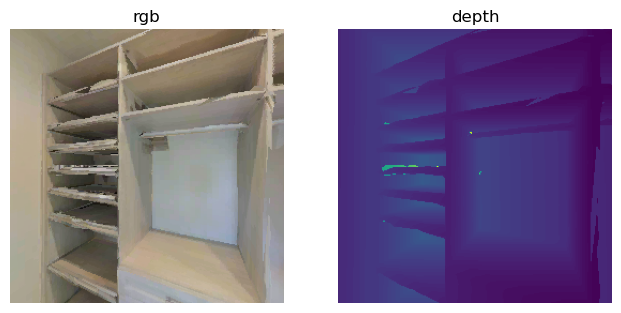

In [25]:
observations = sim.get_sensor_observations()
rgb = observations['color_sensor']
depth = observations['depth_sensor']
display_sample(rgb, np.array([]), depth)

In [26]:
print(sim.pathfinder.is_navigable(agent_pos))
print(agent.get_state().position)
print(agent.get_state().rotation)

False
[-2.46087  3.62461  5.85874]
quaternion(0.979245603084564, 0, 0.202677354216576, 0)


## Scene Position Mapping

In [27]:
# convert 3d points to 2d topdown coordinates
def convert_points_to_topdown(pathfinder, points, meters_per_pixel):
    points_topdown = []
    bounds = pathfinder.get_bounds()
    for point in points:
        # convert 3D x,z to topdown x,y
        px = (point[0] - bounds[0][0]) / meters_per_pixel
        py = (point[2] - bounds[0][2]) / meters_per_pixel
        points_topdown.append(np.array([px, py]))
    return points_topdown


# display a topdown map with matplotlib
def display_map(topdown_map, key_points=None):
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1)
    #ax.axis("off")
    #ax.set_xlim([-30, 30])
    #ax.set_ylim([-30,30])
    plt.imshow(topdown_map)
    # plot points on map
    if key_points is not None:
        for point in key_points:
            plt.plot(point[0], point[1], marker="o", markersize=10, alpha=0.8)
            print(f'Adding point to {point[0]}, {point[1]}')
    plt.show(block=False)

Showing map for scan: 7y3sRwLe3Va
The NavMesh bounds are: (array([-21.601013,  -2.848159,  -3.362628], dtype=float32), array([ 0.793914,  9.748381, 11.962493], dtype=float32))
grid_dimensions: (613, 895)


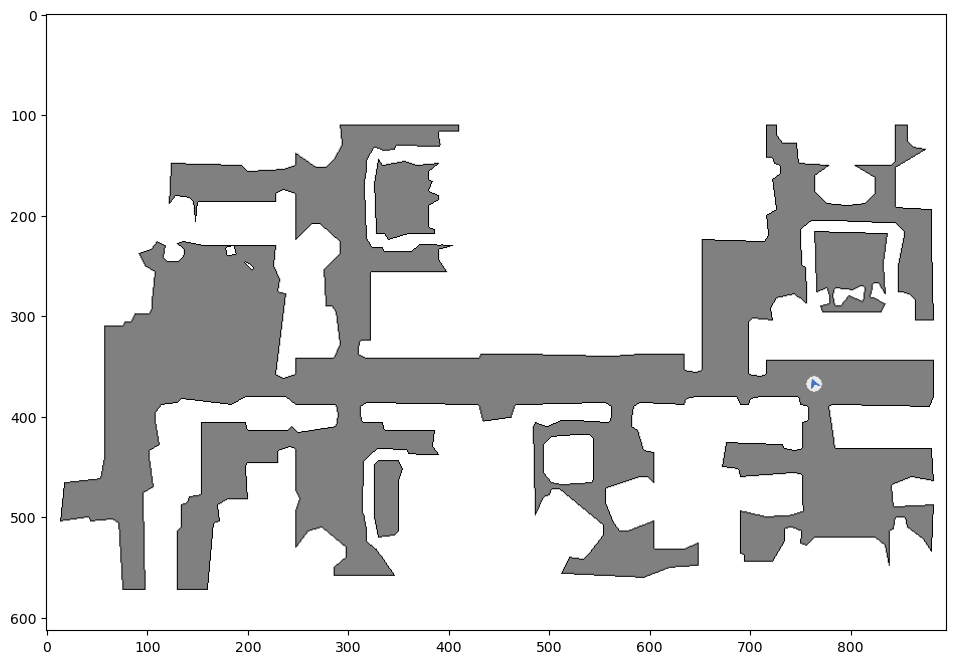

In [28]:
meters_per_pixel = 0.025  # @param {type:"slider", min:0.01, max:1.0, step:0.01}
# @markdown Customize the map slice height (global y coordinate):
custom_height = False  # @param {type:"boolean"}
height = 1  # @param {type:"slider", min:-10, max:10, step:0.1}

print(f"Showing map for scan: {scene_id}")
print("The NavMesh bounds are: " + str(sim.pathfinder.get_bounds()))
if not custom_height:
    # get bounding box minimum elevation for automatic height
    height = sim.pathfinder.get_bounds()[0][1]

if not sim.pathfinder.is_loaded:
    print("Pathfinder not initialized, aborting.")
else:
    if display:
        agent_pos = agent_state.position
        
        hablab_topdown_map = maps.get_topdown_map(
            sim.pathfinder, height=agent_pos[1], meters_per_pixel=meters_per_pixel
        )
        recolor_map = np.array(
            [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
        )
        
        hablab_topdown_map = recolor_map[hablab_topdown_map]
        grid_dimensions = (hablab_topdown_map.shape[0], hablab_topdown_map.shape[1])
        print(f'grid_dimensions: {grid_dimensions}')
        
        agent_grid_pos = maps.to_grid(agent_pos[2], agent_pos[0], grid_dimensions, pathfinder=sim.pathfinder)

        agent_forward = utils.quat_to_magnum(
            sim.agents[0].get_state().rotation
        ).transform_vector(mn.Vector3(0, 0, -1.0))
        agent_orientation = math.atan2(agent_forward[0], agent_forward[2])
        
        maps.draw_agent(hablab_topdown_map, agent_grid_pos, agent_orientation, agent_radius_px=8)
        
        #print("Displaying the map from the Habitat-Lab maps module:")
        display_map(hablab_topdown_map)
        
        # easily save a map to file:
        #map_filename = f"top_down_map.png"
        #imageio.imsave(f'/home/wes/Documents/test_development/outputs/{map_filename}', hablab_topdown_map)

In [29]:
agent_state.position

array([-2.46087003,  3.62460995,  5.85873985])

## Test: Video

In [30]:
sim_time = 10
continuous_nav = True

control_frequency = 5
frame_skip = 12

fps = control_frequency * frame_skip # 60 fps
print(f"fps: {fps}")

control_sequence = []
for action in range(int(sim_time * control_frequency)):  #120 actions, spread across 60 fps
    control_sequence.append(
        {
            "rotation_velocity" : -0.3 * 2.0,
            "forward_velocity" : 0.1,
        }
    )

observations = []

velocity_control = habitat_sim.physics.VelocityControl()
velocity_control.controlling_lin_vel = True
velocity_control.lin_vel_is_local = True
velocity_control.controlling_ang_vel = True
velocity_control.ang_vel_is_local = True

# manually controlling the object's kinematic state via velocity integration
time_step = 1.0 / (frame_skip * control_frequency) # 1 / fps

for i, action in enumerate(control_sequence):
    velocity_control.linear_velocity = np.array([0, 0, -action["forward_velocity"]])
    velocity_control.angular_velocity = np.array([0, action["rotation_velocity"], 0])

    for frame in range(frame_skip):
        #agent_state = agent.state
        previous_rigid_state = habitat_sim.RigidState(utils.quat_to_magnum(agent_state.rotation), agent_state.position)
    
        # manually integrating the rigid state
        target_rigid_state = velocity_control.integrate_transform(time_step, previous_rigid_state)
    
        # snap rigid state to navmesh and set state to object/agent
        end_pos = sim.step_filter(previous_rigid_state.translation, target_rigid_state.translation)

        if False: #frame < 10 and i < 2:
            print(f'agent_state.position {frame}: {agent_state.position}')
            print(f'previous_rigid_state {frame}: {previous_rigid_state.translation}')
            print(f'target_rigid_state {frame}: {target_rigid_state.translation}')
            print(f'end_pos {frame}: {end_pos}')
    
        # setting the computer state
        agent_state.position = end_pos # + np.array([0, height, 0])
        agent_state.rotation = utils.quat_from_magnum(target_rigid_state.rotation)
        agent.set_state(agent_state)
    
        # checking if a collision occured
        dist_moved_before_filter = (target_rigid_state.translation - previous_rigid_state.translation).dot()
        dist_moved_after_filter = (end_pos - previous_rigid_state.translation).dot()
    
        EPS = 1e-5
        collided = (dist_moved_after_filter + EPS) < dist_moved_before_filter
        if collided:
            print(f'collision on frame: {frame}, action: {i}')
    
        sim.step_physics(time_step)
        observations.append(sim.get_sensor_observations())

print(f"frames: {str(len(observations))}")
vut.make_video(
    observations = observations,
    primary_obs = "color_sensor",
    primary_obs_type = "color",
    video_file = os.path.join(output_dir_path, "test_video"),
    fps = fps,
    open_vid = show_video,
)

fps: 60
frames: 600
Encoding the video: /home/wes/Documents/git_ws/OCOM5300M_ResearchProject/outputs/test_video.mp4 


In [31]:
agent_state.position

Vector(-2.43609, 3.15184, 5.89872)

## Creating panoramic view of current position

In [32]:
# snapping the agent back to original orientation
agent_state.position = agent_pos
agent_state.rotation = agent_rotation
agent.set_state(agent_state)

In [33]:
print(agent_state.position)
print(agent_state.rotation)

[-2.46087003  3.62460995  5.85873985]
quaternion(0.979245603084564, 0, 0.202677354216576, 0)


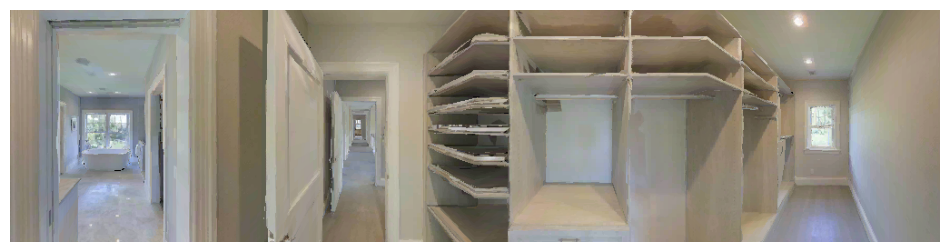

In [78]:
number_of_captures = int(360 / sim_settings["hfov"])
rotation_size = sim_settings["hfov"]
mid_index = int(number_of_captures/2)
color_observations = []

for i in range(number_of_captures):
    agent_state = agent.get_state()
    agent_state.rotation = habitat_sim.utils.quat_from_angle_axis(
            np.deg2rad(-rotation_size * i), np.array([0, 1, 0])  # Y-axis rotation
        )
    agent.set_state(agent_state)
    observations = sim.get_sensor_observations()
    color_observations.append(observations['color_sensor'])

color_observations = color_observations[-mid_index:] + color_observations[:mid_index]

agent_views = {
    "forward" : color_observations[2],
    "left" : color_observations[1],
    "right" : color_observations[3],
    "behind": color_observations[0]
}


panoramic_image = cv2.hconcat(color_observations)

'''
color_observations = [obs[:,:,:3] for obs in color_observations]

stitcher = cv2.Stitcher_create()
status, pano = stitcher.stitch(color_observations)


cv2.imshow('Ego-centric panoramic image', pano)
cv2.waitKey(0)
cv2.destroyAllWindows()
'''
plt.figure(figsize=(12, 8))
plt.imshow(panoramic_image)
plt.axis('off')  # Hide axes
plt.show()

In [79]:
#sim.close()